In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import ee

def authenticate():
    # import code_verifier and authorization_code from misc/ee_auth.txt
    with open("Q:/HEALECON/Felix/Research/Heat Islands/misc/ee_auth.txt", "r") as f:
        code_verifier, authorization_code = f.read().split("\n")

    # Trigger the authentication flow.
    ee.Authenticate()# code_verifier=code_verifier, authorization_code = authorization_code
    # Initialize the Earth Engine module
    ee.Initialize(project = "ee-growthandheat")


In [6]:
authenticate()

# Load ERA5-Land Monthly Data (temperature in Kelvin)
era5 = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_BY_HOUR")

# Function to compute annual mean temperature for a given year
def annual_mean_temp(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = start_date.advance(1, "year")
    
    return (era5
            .filterDate(start_date, end_date)
            .select("temperature_2m")
            .mean()
            .set("year", year)
           )


# Export annual mean temperatures for 1990-1999, 2010-2019
years = list(range(1990, 2000)) + list(range(2010, 2020))
for year in years:
    
    tmp = annual_mean_temp(year)
    
    export_task = ee.batch.Export.image.toCloudStorage(
        image=tmp,
        description="ERA5_Temperature_{}".format(year),
        bucket="growthandheat",
        crs="EPSG:4326",
        scale = 10000,
        region=ee.Geometry.BBox(-180, -90, 180, 90),
        fileFormat="GeoTIFF"
    )
    
    export_task.start()

In [9]:
from google.cloud import storage

# Replace 'your-key.json' with the path to your JSON key file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "Q:/HEALECON/Felix/Research/Heat Islands/misc/ee-growthandheat-570de7e75ef6.json"
storage_client = storage.Client("ee-growthandheat")

bucket = storage_client.bucket("growthandheat")

# Construct a client side representation of a blob.
# Note `Bucket.blob` differs from `Bucket.get_blob` as it doesn't retrieve
# any content from Google Cloud Storage. As we don't need additional data,
# using `Bucket.blob` is preferred here.
for year in years:
    source_blob_name = f"ERA5_Temperature_{year}.tif"
    blob = bucket.blob(source_blob_name)
    destination_file_name = f"Q:/HEALECON/Felix/Research/Heat Islands/data/era5/ERA5_Temperature_{year}.tif"
    blob.download_to_filename(destination_file_name)

---

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import shapely
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt

In [2]:
temperatures = os.listdir("Q:/HEALECON/Felix/Research/Heat Islands/data/era5")
temperatures = [t for t in temperatures if t.endswith(".tif")]

In [3]:
temperatures_199X = [t for t in temperatures if "199" in t]
temperatures_201X = [t for t in temperatures if "201" in t]

# Load the rasters
era5_199X = [rxr.open_rasterio("Q:/HEALECON/Felix/Research/Heat Islands/data/era5/{}".format(t)) for t in temperatures_199X]
era5_201X = [rxr.open_rasterio("Q:/HEALECON/Felix/Research/Heat Islands/data/era5/{}".format(t)) for t in temperatures_201X]

In [4]:
# Compute annual mean temperature
temperature_difference = xr.concat(era5_201X, dim="year").mean(dim="year") - xr.concat(era5_199X, dim="year").mean(dim="year")
temperature_difference = temperature_difference.rio.clip_box(-180, -60, 180, 90)

In [5]:
settlements = rxr.open_rasterio("Q:\HEALECON\Felix\Research\Heat Islands\data\GHS_BUILT_S_E2020_GLOBE_R2023A_4326_30ss_V1_0\GHS_BUILT_S_E2020_GLOBE_R2023A_4326_30ss_V1_0.tif")
settlements = settlements.rio.reproject_match(temperature_difference)

In [21]:
settlement_model = rxr.open_rasterio("Q:/HEALECON/Felix/Research/Heat Islands/data/GHS_SMOD_E2020_GLOBE_R2023A_54009_1000_V2_0/GHS_SMOD_E2020_GLOBE_R2023A_54009_1000_V2_0.tif")
settlement_model_rural = ((settlement_model >= 10) & (settlement_model <= 13)) # rural as defined by definition on page 54 of the documentation
settlement_model_urban_center = (settlement_model == 30) # urban center as defined by definition on page 54 of the documentation
settlement_model_populated = ((settlement_model >= 12) & (settlement_model <= 30)) 
settlement_model_populated_nourbancenter = ((settlement_model >= 12) & (settlement_model <= 30))

In [7]:
population = rxr.open_rasterio("Q:/HEALECON/Felix/Research/Heat Islands/data/GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0/GHS_POP_E2020_GLOBE_R2023A_54009_1000_V1_0.tif")
population = population.where(population != -200, np.nan)

In [8]:
urban_center_population = population.where(settlement_model_urban_center, np.nan).sum()
urban_center_population.values

array(3.49515448e+09)

In [9]:
urban_center_population.values / population.sum().values

0.44575633941975956

In [10]:
rural_population = population.where(settlement_model_rural, np.nan).sum()
rural_population.values

array(1.58440811e+09)

In [11]:
rural_population.values / population.sum().values

0.20206831031117473

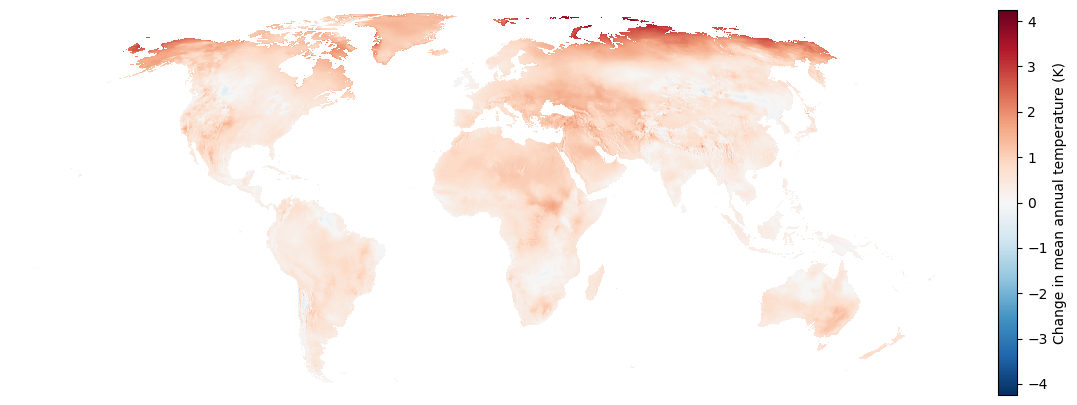

In [12]:
fig, ax = plt.subplots(figsize = (15, 5))

from cartopy import crs as ccrs
temperature_difference.rio.reproject(ccrs.Robinson().proj4_init).squeeze().plot.imshow(ax = ax, add_labels=False, cbar_kwargs={'label': "Change in mean annual temperature (K)"})
#(settlements > 0).where(settlements > 0, np.nan).squeeze().plot.imshow(ax = ax, levels = 2, colors = "black", alpha = 0.1, add_colorbar=False, add_labels=False)

plt.axis('off')
fig.savefig("Q:/HEALECON/Felix/Research/Heat Islands/output/figures/temperature_difference.png", 
            bbox_inches = "tight", dpi = 300, transparent = True)

In [22]:
settlement_model_urban_center_reprojected = (settlement_model_urban_center * 1).rio.reproject_match(temperature_difference)
settlement_model_populated_reprojected = (settlement_model_populated * 1).rio.reproject_match(temperature_difference)
settlement_model_populated_nourbancenter_reprojected = (settlement_model_populated_nourbancenter * 1).rio.reproject_match(temperature_difference)

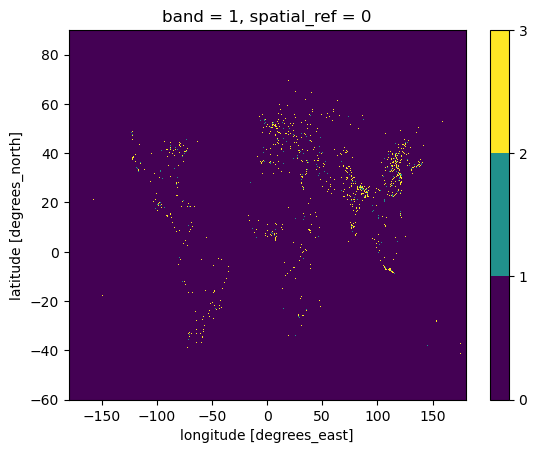

In [19]:
from scipy.ndimage import binary_dilation

mask = (settlement_model_urban_center_reprojected == 1)

# Define buffer size (number of pixels)
u = 1

# Create structuring element (square shape with radius u)
structure = np.ones((2 * u + 1, 2 * u + 1), dtype=bool)

# Apply binary dilation
buffered_mask = mask.copy()
buffered_mask.values = binary_dilation(mask.squeeze(), structure=structure).reshape(mask.shape)

# Difference between buffered and original mask
buffered_mask = buffered_mask.where(buffered_mask != mask, False)

plot_data = (mask) + (buffered_mask * 2)

# Display result
plot_data.squeeze().plot.imshow(levels = [0, 1, 2, 3])

In [15]:
temperature_difference.mean().values

array(0.76457082)

In [16]:
temperature_difference.where(settlement_model_urban_center_reprojected == 1, np.nan).mean().values

array(0.48912952)

In [23]:
temperature_difference.where(settlement_model_populated_nourbancenter_reprojected == 1, np.nan).mean().values

array(0.47650147)

In [20]:
temperature_difference.where(buffered_mask, np.nan).mean().values

array(0.51029389)

In [17]:
temperature_difference.where(settlement_model_populated_reprojected == 1, np.nan).mean().values

array(0.47650147)